In [95]:
import tarfile
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy.random import rand
from numpy import log, exp, matmul
from numpy.random import default_rng

In [96]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz")
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz")
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("../comp0090_assignment_1_data/fashion-test-imgs.npz")
testys  = np.load("../comp0090_assignment_1_data/fashion-test-labels.npz");

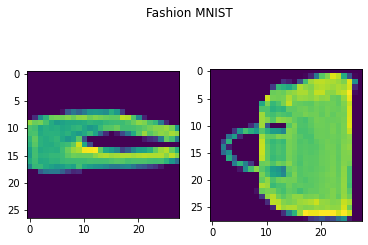

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fashion MNIST')
ax1.imshow(trainxs[1:,:,0])
ax2.imshow(trainxs[:,:,7])

In [189]:
def showResults(epochs, loss_train, loss_val, acc_train, acc_val, max_val_acc_epoch):
    print('The accuracy on the training and validation set, for the epoch on which we get the highest accuracy on the validation set is: {} / {} at epoch {}.'.format(acc_train[max_val_acc_epoch], acc_val[max_val_acc_epoch], max_val_acc_epoch+1))   

    plt.figure(figsize=(12, 5))
    plt.suptitle("Loss and Accuracy Results of Training and Validation set", fontsize = 16)

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_train, label="Training Loss")
    plt.plot(range(epochs), loss_val, label="Validation Loss")
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Loss', fontsize = 13)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_train, label="Training Accuracy")
    plt.plot(range(epochs), acc_val, label="Validation Accuracy")
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Accuracy', fontsize = 13)
    plt.legend()

    plt.show()

In [248]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  2 20:36:43 2020

@author: Pavlos
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy.random import rand
from numpy import exp, matmul
from numpy.random import default_rng


def loadData(filename):
    file = os.path.join(os.getcwd(), os.pardir, "comp0090_assignment_1_data", filename)
    return np.load(file)

def shuffleIdx(n):
    rng = default_rng()
    rand_idx = rng.permutation(n)
    return rand_idx

def initialiseMLP():
    mlp_params = {'W': np.random.rand(inputPar,1)/100,
           'b': np.zeros((1, 1))}

    keys = iter(mlp_params)
    layers_sizes = [inputPar, 1]
    len(layers_sizes)
    for s in range(len(layers_sizes)-1):
        key = next(keys)
        epsilon = 4.0 * np.sqrt(6) / np.sqrt(layers_sizes[s] + layers_sizes[s+1])
        mlp_params[key] = epsilon * ( (rand(layers_sizes[s+1], layers_sizes[s]) * 2.0 ) - 1)
    
    return mlp_params


trainxs = loadData("fashion-train-imgs.npz").reshape(784, 1, -1)
trainys = loadData("fashion-train-labels.npz")
devxs   = loadData("fashion-dev-imgs.npz").reshape(784, 1, -1)
devys   = loadData("fashion-dev-labels.npz")


############################IMPORTANT PARAMETERS#############################
epochs=600
inputPar = trainxs.shape[0] * trainxs.shape[1]
###################################

mlp_params = initialiseMLP()
grad_mlp = copy.deepcopy(mlp_params)

sig = lambda x : 1/(1 + exp(-x))
sigPrime = lambda x : sig(x)*(1 - sig(x))
a1 = lambda m, x : matmul(m['W'], x)[0,0] + m['b'][0,0]
f = h1 = lambda m, x : sig(a1(m,x))

########### LEARNING PROCESS ################
lr = 0.1
losslist_train = []
losslist_val = []
acclist_train = []
acclist_val = []

max_val_acc_epoch = 0
n_samples = trainxs.shape[2]
n_samples_val = devxs.shape[2]

for e in range(epochs):
    idx = shuffleIdx(trainxs.shape[2])
    X = trainxs[:, :, idx]
    Y = trainys[idx]
    
    loss_train = 0
    loss_val = 0
    
    acc_train = 0
    train_correct = 0
    val_correct = 0
    cnt = 1
    
    total_grad = {'W': np.zeros((1, inputPar)),
             'b': np.zeros((1, 1))}
    
    # UPDATE GRADIENTS FOR EACH IMAGE IN THE TRAINING DATASET
    for i in range(trainxs.shape[2]): #number of data
        x = X[:, :, i]
        y = Y[i]
        
        prediction = f(mlp_params,x)
        
        if prediction >= 0.5:
            yprime = 1
        else:
            yprime = 0
            
        if yprime == y:
            train_correct += 1
            
        
        loss_train += ((y - prediction)**2)/2
        
        grad_mlp['b'][0,0] = -(y-prediction)*(prediction)*(1-prediction)
        grad_mlp['W'] = grad_mlp['b'][0,0] * x
        
        # SUM THE GRADIENTS OF X
        for key in mlp_params:
            total_grad[key] += grad_mlp[key].T
            
                
    # COMPUTING LOSS AND ACCURACY OF VALIDATION SET
        if (i < devxs.shape[2]):
            val_x = devxs[:, :, i]
            val_y = devys[i]
            
            prediction = f(mlp_params,val_x)
            if prediction  >= 0.5:
                yprime = 1
            else:
                yprime = 0

            if yprime == val_y:
                val_correct += 1
                
            loss_val += ((val_y - prediction)**2)/2


    # COMPUTING THE AVERAGE OF GRADIENTS FOR EACH EPOCH SINCE WE ARE DOING        
    # FULL-BATCH GRADIENT DESCEND AND UPDATING THE PARAMETERS AFTER EACH EPOCH
    for key in total_grad:
        total_grad[key] = total_grad[key]/n_samples
        mlp_params[key] -= lr * total_grad[key]
    
    loss_train = loss_train/n_samples
    losslist_train.append(loss_train)
    
    loss_val = loss_val/(n_samples_val)
    losslist_val.append(loss_val)
    
    train_correct = train_correct/n_samples
    acclist_train.append(train_correct)
    
    val_correct = val_correct/(n_samples_val)
    acclist_val.append(val_correct)
    


    if  val_correct > acclist_val[max_val_acc_epoch]:
        max_val_acc_epoch = e

    print("- Loss on Training / Validation Data at Epoch {}: {:.4f} / {:.4f}".format(e+1, loss_train, loss_val)) 
    print("- Accuracy on Training / Validation Data at Epoch {}: {} / {}\n".format(e+1, train_correct, val_correct))

def showResults(epochs, loss_train, loss_val, acc_train, acc_val, max_val_acc_epoch):
    print('The accuracy on the training and validation set, for the epoch on which we get the highest accuracy on the validation set is: {} / {} at epoch {}.'.format(acc_train[max_val_acc_epoch], acc_val[max_val_acc_epoch], max_val_acc_epoch+1))   

    plt.figure(figsize=(12, 5))
    plt.suptitle("Loss and Accuracy Results of Training and Validation set", fontsize = 16)

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_train, label="Training Loss")
    plt.plot(range(epochs), loss_val, label="Validation Loss")
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Loss', fontsize = 13)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_train, label="Training Accuracy")
    plt.plot(range(epochs), acc_val, label="Validation Accuracy")
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Accuracy', fontsize = 13)
    plt.legend()

    plt.show()


showResults(epochs, losslist_train, losslist_val, acclist_train,acclist_val, max_val_acc_epoch)


- Loss on Training / Validation Data at Epoch 1: 0.1043 / 0.1063
- Accuracy on Training / Validation Data at Epoch 1: 0.6776666666666666 / 0.682

- Loss on Training / Validation Data at Epoch 2: 0.1020 / 0.1040
- Accuracy on Training / Validation Data at Epoch 2: 0.6865833333333333 / 0.689

- Loss on Training / Validation Data at Epoch 3: 0.0999 / 0.1018
- Accuracy on Training / Validation Data at Epoch 3: 0.6945833333333333 / 0.701

- Loss on Training / Validation Data at Epoch 4: 0.0979 / 0.0997
- Accuracy on Training / Validation Data at Epoch 4: 0.7030833333333333 / 0.71

- Loss on Training / Validation Data at Epoch 5: 0.0960 / 0.0978
- Accuracy on Training / Validation Data at Epoch 5: 0.70925 / 0.716

- Loss on Training / Validation Data at Epoch 6: 0.0942 / 0.0960
- Accuracy on Training / Validation Data at Epoch 6: 0.7165833333333333 / 0.722

- Loss on Training / Validation Data at Epoch 7: 0.0924 / 0.0942
- Accuracy on Training / Validation Data at Epoch 7: 0.723 / 0.723

- L

KeyboardInterrupt: 

In [249]:
sig = lambda x : 1/(1 + exp(-x))
sigPrime = lambda x : sig(x)*(1 - sig(x))
a1 = lambda m, x : matmul(m['W'], x)[0,0] + m['b'][0,0]
f = h1 = lambda m, x : sig(a1(m,x))

def checkGradient(mlp_params, X, Y):
    # COMPARE AND CHECK ANALYTICAL GRADIENT WITH FINITE DIFFERENCE GRADIENT OF PARAMETERS
    for s in range(X.shape[2]):
        print("\n- Sample ", s+1)
        x = X[:,:,s].reshape(784, 1);
        grad_mlp = copy.deepcopy(mlp_params)
        prediction = f(mlp_params,x)
        grad_mlp['b'][0,0] = -(y-prediction)*(prediction)*(1-prediction)
        grad_mlp['W'] = grad_mlp['b'][0,0] * x.T
        inputPar = trainxs.shape[0] * trainxs.shape[1]

        fdgrad_mlp = copy.deepcopy(mlp_params)
        diff_grad_mlp = copy.deepcopy(mlp_params)
        check_mlp = {'W': False, 'b': False}

        # COMPUTE FINITE DIFFERENCE GRADIENT OF PARAMETERS
        eps = 0.00001

        for key, par in mlp_params.items():
            for i in range(par.shape[0]):
                for j in range(par.shape[1]):
                    temp = par[i,j]
                    par[i,j] += eps/2
                    r = ((Y[s] - f(mlp_params,x))**2)/2
                    par[i,j] = temp
                    par[i,j] -= eps/2
                    l = ((Y[s] - f(mlp_params,x))**2)/2
                    par[i,j] = temp

                    fdgrad_mlp[key][i,j] = (r-l)/eps
                    diff_grad_mlp[key][i,j] = abs(fdgrad_mlp[key][i,j] - grad_mlp[key][i,j])

            check_mlp[key] = (diff_grad_mlp[key] < 1e-6).all()


        print("\nCheck if the difference between Analytical Gradient and Finite Difference Gradient of parameters is below 1e-6 threshold:")
        print(check_mlp, "\n")

In [251]:
mlp_params = initialiseMLP()
checkGradient(mlp_params, trainxs[:,:,[300,1000]], trainys[[300,1000]])


- Sample  1

Check if the difference between Analytical Gradient and Finite Difference Gradient of parameters is below 1e-6 threshold:
{'W': True, 'b': True} 


- Sample  2

Check if the difference between Analytical Gradient and Finite Difference Gradient of parameters is below 1e-6 threshold:
{'W': True, 'b': True} 

